## Data preprocessing

##### Copyright (C) Microsoft Corporation.  
see license file for details

In [1]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

In [2]:
# import utlity functions

import sys, os
paths_to_append = [os.path.join(os.getcwd(), os.path.join(*(['..','tsne_python','Code',  'src'])))]
def add_path_to_sys_path(path_to_append):
    if not (any(path_to_append in paths for paths in sys.path)):
        sys.path.append(path_to_append)

[add_path_to_sys_path(crt_path) for crt_path in paths_to_append]

import trvis_utils, image_featurization

[None]

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Path variables

In [3]:
data_base_input_dir = '/datadrive/dogs_vs_cats/dogs_vs_cats_keras'
data_dir = os.path.join(data_base_input_dir, 'train')
output_dir = os.path.join(data_base_input_dir, 'processed')
os.makedirs(output_dir, mode=0o777, exist_ok=True)


In [4]:
from keras.applications.resnet50 import ResNet50
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import random


from keras.layers import Dense
from keras.models import Model
from keras_contrib.applications.densenet import DenseNetImageNet121
import keras_contrib

In [ ]:
RECOMPUTE=False
SAMPLE_DATA = False
    

In [5]:
# densenet layers
# name          size    connected_to
# dense_2_3_bn  1408    concatenate_311
# dense_2_8_bn  2048    concatenate_316 
# dense_2_10_bn 2304    concatenate_318  
              
# model_name_list = [ResNet50, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121]
# model_layer_list = ['','dense_2_3_bn', 'dense_2_8_bn', 'dense_2_10_bn', '']    
model_name_list = [ResNet50]
model_layer_list = ['']

sample_size = 1000
saved_data_file_appendix = ''
if SAMPLE_DATA:
    saved_data_file_appendix = '_sample'

In [6]:

import matplotlib.pyplot as plt


#import matplotlib
#matplotlib.use('agg')

%matplotlib inline


In [7]:
training_image_files = os.listdir(data_dir)

if SAMPLE_DATA:
    training_image_files= random.sample(training_image_files, sample_size)

len(training_image_files)
training_image_files[:2]
image_file_names = list(os.path.join(data_dir, fname) for fname in training_image_files)
image_file_names[:2]

20000

['dog.213.jpg', 'dog.6445.jpg']

['/datadrive/dogs_vs_cats/dogs_vs_cats_keras/train/dog.213.jpg',
 '/datadrive/dogs_vs_cats/dogs_vs_cats_keras/train/dog.6445.jpg']

#### Featurization

In [8]:
class pretrained_model:
    def __init__(self, DL_architecture, intermediate_layer = ''):
        self.name = DL_architecture.__name__
        pooling_value = 'avg'
        if DL_architecture.__name__=='DenseNetImageNet121':
            pooling_value = 'None'
        crt_model = DL_architecture(input_shape=(224, 224, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling=pooling_value)
        if not (intermediate_layer==''):
             crt_model = Model(inputs=crt_model.input, outputs=crt_model.get_layer(intermediate_layer).output)
        self.model = crt_model

def pretrained_models_generator(model_name_list):
    """Yield successive pretrained models."""
    for crt_model_name in model_name_list: 
        yield pretrained_model(crt_model_name)
   
# crt_pretrained_models = [pretrained_model(ResNet50), pretrained_model(DenseNetImageNet121)]
# print(crt_model.name for crt_model in crt_pretrained_models)
# models = dict([ (m.name, m.model) for m in crt_pretrained_models ])

In [9]:
def featurize_images_multiple_models(crt_image_file_names, output_dir, model_name_list, batch_size=64):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('processing model ' + crt_model_name.__name__+' layer '+crt_model_layer)
        features_filename = os.path.join(output_dir, 'features_' +\
                                         crt_model_name.__name__+saved_data_file_appendix+\
                                         crt_model_layer+'.npy')
        if os.path.isfile(features_filename) and RECOMPUTE is False:
            print("Features found!")
        else:
            print("Computing features")
            crt_model = pretrained_model(crt_model_name, crt_model_layer).model
            features = image_featurization.featurize_images(crt_image_file_names, crt_model, batch_size) 
            print(features.shape)
            np.save(features_filename, features)
            del crt_model



In [10]:
%%time
featurize_images_multiple_models(image_file_names, output_dir, model_name_list)            

processing model ResNet50 layer 
Computing features
Instructions for updating:
keep_dims is deprecated, use keepdims instead


313it [02:56,  1.78it/s]


(20000, 2048)
CPU times: user 2min 41s, sys: 33.7 s, total: 3min 15s
Wall time: 3min 4s


#### TSNE sklearn

In [11]:
def apply_tsne_to_multiple_features(output_dir, crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('tsne processing for model ' + crt_model_name.__name__)
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        if os.path.isfile(tsne_features_filename) and RECOMPUTE is False:
            print("tsne features found!")
        else:
            print("Computing tsne features")
            original_features = np.load(os.path.join(output_dir, 'features_' + \
                                                     crt_model_name.__name__+saved_data_file_appendix+\
                                                     crt_model_layer+'.npy'))
            print(original_features.shape)
            original_features = original_features.reshape(original_features.shape[0], -1)
            print(original_features.shape)
            images_tsne = TSNE(n_components=2, random_state=0, verbose=1).fit_transform(original_features)
            print(images_tsne.shape)
            np.save(tsne_features_filename, images_tsne)


In [12]:
%%time
apply_tsne_to_multiple_features(output_dir, model_name_list)                        

tsne processing for model ResNet50
Computing tsne features
(20000, 2048)
(20000, 2048)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 2.985s...
[t-SNE] Computed neighbors for 20000 samples in 1426.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional

In [13]:
labels_filename = os.path.join(output_dir, 'labels_' + \
                                              saved_data_file_appendix+\
                                              '.npy')
if os.path.isfile(labels_filename) and RECOMPUTE is False:
    print('Label file '+labels_filename+' found!')
    y = np.load(labels_filename)
else:
  y = pd.Series(training_image_files).str.contains('cat').astype(int).values
  np.save(labels_filename, y)

print(y.shape)
print(y[y==0].shape)
print(y[y==1].shape)


(20000,)
(10000,)
(10000,)


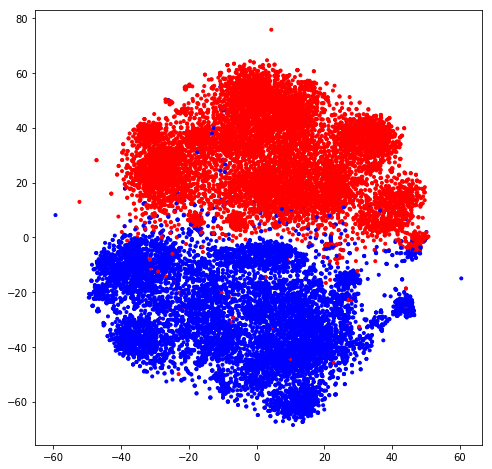

In [14]:
cat_labels = y == 0
dog_labels = y == 1
def visualize_tsne_features(crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        tsne_features = np.load(tsne_features_filename)
        plt.figure(figsize=(8, 8))
        plt.scatter(x = tsne_features[:,0], y=tsne_features[:,1], marker=".", c=y, cmap=plt.cm.get_cmap('bwr'))

        plt.show()
        
visualize_tsne_features(model_name_list)      